In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
#from sklearn.metrics import plot_precision_recall_curve


d:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
d:\Python\Python39\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


              precision    recall  f1-score   support

        Fake       1.00      0.07      0.14       110
     Genuine       0.35      1.00      0.52        55

    accuracy                           0.38       165
   macro avg       0.68      0.54      0.33       165
weighted avg       0.78      0.38      0.26       165



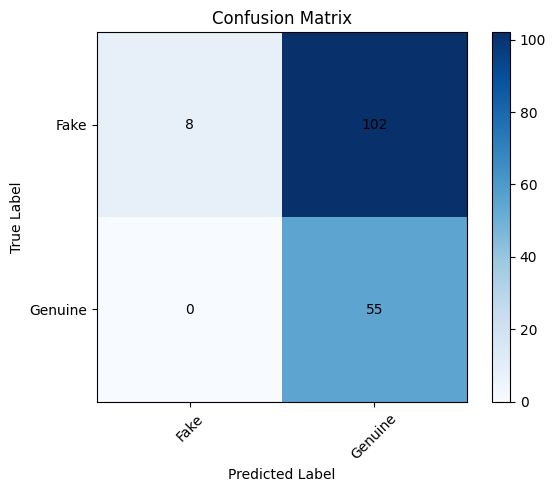

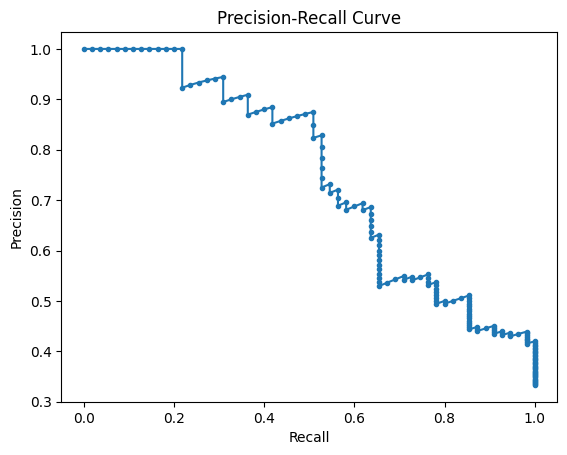

In [4]:

# Custom dataset class
class CustomLogoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for label, subdir in enumerate(['Fake', 'Genuine']):
            folder_path = os.path.join(self.root_dir, subdir)
            for filename in os.listdir(folder_path):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    self.images.append(os.path.join(folder_path, filename))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Image transformations
image_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # InceptionV3 input size
    transforms.ToTensor(),
])

# Load the trained model
def load_trained_model(model_path):
    model = models.inception_v3(pretrained=False)
    num_classes = 2
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Function to classify a dataset
def classify_dataset(dataset, model, device):
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for images, labels in dataset:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return true_labels, predicted_labels

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i][j]), ha='center', va='center')
    plt.show()

# Function to plot precision-recall curve
def plot_precision_recall(true_labels, predicted_scores):
    precision, recall, _ = precision_recall_curve(true_labels, predicted_scores)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the trained model
    model_path = 'inception_fake_real_logo_detection_model.pth'
    model = load_trained_model(model_path)
    model = model.to(device)

    # Prepare test dataset
    test_dataset = CustomLogoDataset('FakeReal Logo Detection dataset/test', transform=image_transforms)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Classify test dataset
    true_labels, predicted_labels = classify_dataset(test_dataloader, model, device)

    # Calculate and print classification report
    target_names = ['Fake', 'Genuine']
    print(classification_report(true_labels, predicted_labels, target_names=target_names))

    # Plot confusion matrix
    plot_confusion_matrix(true_labels, predicted_labels, classes=target_names)

    # Calculate predicted scores for precision-recall curve
    predicted_scores = []
    with torch.no_grad():
        for images, labels in test_dataset:
            images = images.unsqueeze(0).to(device)
            outputs = model(images)
            predicted_scores.extend(outputs[:, 1].cpu().numpy())  # Assuming second column corresponds to 'Genuine' class

    # Plot precision-recall curve
    plot_precision_recall(true_labels, predicted_scores)
